# Bilateral Denoising

As final models the following 3 algorithms were chosen:
* FaceNet512
* ArcFace
* VGG-Face

In [1]:
%cd /tf/notebooks

/tf/notebooks


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import itertools
from itertools import permutations
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from PIL import Image
from sklearn.metrics import roc_auc_score, accuracy_score
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as st
import tensorflow as tf

from utils import (
    calculate_confidence_interval, calculate_performance_per_threshold,
    count_distances,plot_performance_per_threshold,
    get_metric_comparision, plot_score_distribution,
    perform_significance_test, calculate_distribution_difference,plot_face_heatmap
)
from skimage.restoration import denoise_bilateral


import cv2
from deepface import DeepFace


In [4]:
def load_image(shape,path,preprocessing = None):
    if preprocessing is not None:
        img = Image.open(path).resize(shape)
        img = np.array(img)
        img = preprocessing(img)
    else:
        img = Image.open(path).resize(shape)
        img = np.array(img)
    return img

In [5]:
def bilateral_denoising(img):  
    #img = Image.open(img)
    return cv2.bilateralFilter(img, 15, 75, 75)

## Example

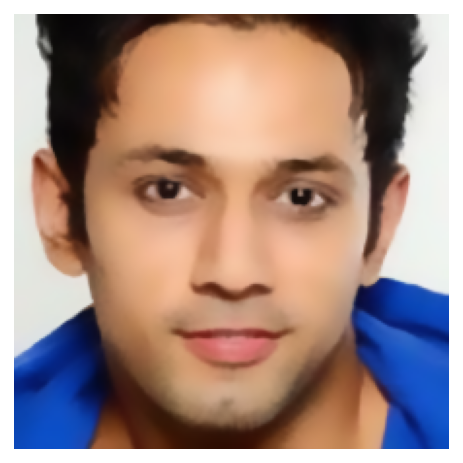

In [6]:
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = bilateral_denoising)
plt.imshow(indian_img)
plt.axis('off');

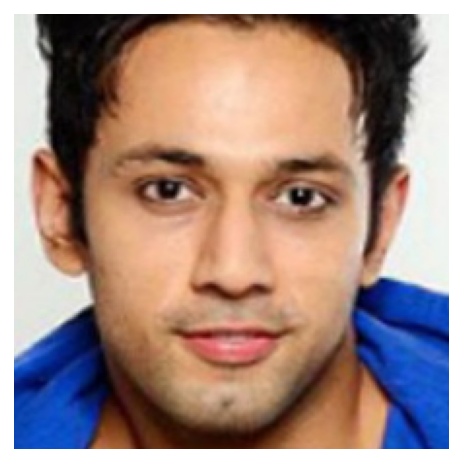

In [7]:
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = None)
plt.imshow(indian_img)
plt.axis('off');

# Evaluation

## Performance comparison

Due to the balanced target labels (50% pairs and 50% non-pairs) we chose to use Accuracz and AUROC as evaluation metrics.

### Facenet512

In [8]:
facenet_model = "facenet_bilateral_denoising"

In [9]:
facenet_summary = get_metric_comparision(facenet_model, roc_auc_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.927621,0.926609,0.928633
0,African,0.906664,0.905495,0.907834
0,Asian,0.903961,0.902907,0.905014
0,Caucasian,0.883436,0.882153,0.884719


In [10]:
facenet_summary = get_metric_comparision(facenet_model, accuracy_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.839297,0.837934,0.840660
0,Asian,0.830083,0.828771,0.831395
0,African,0.830037,0.828578,0.831495
0,Caucasian,0.755753,0.754264,0.757243


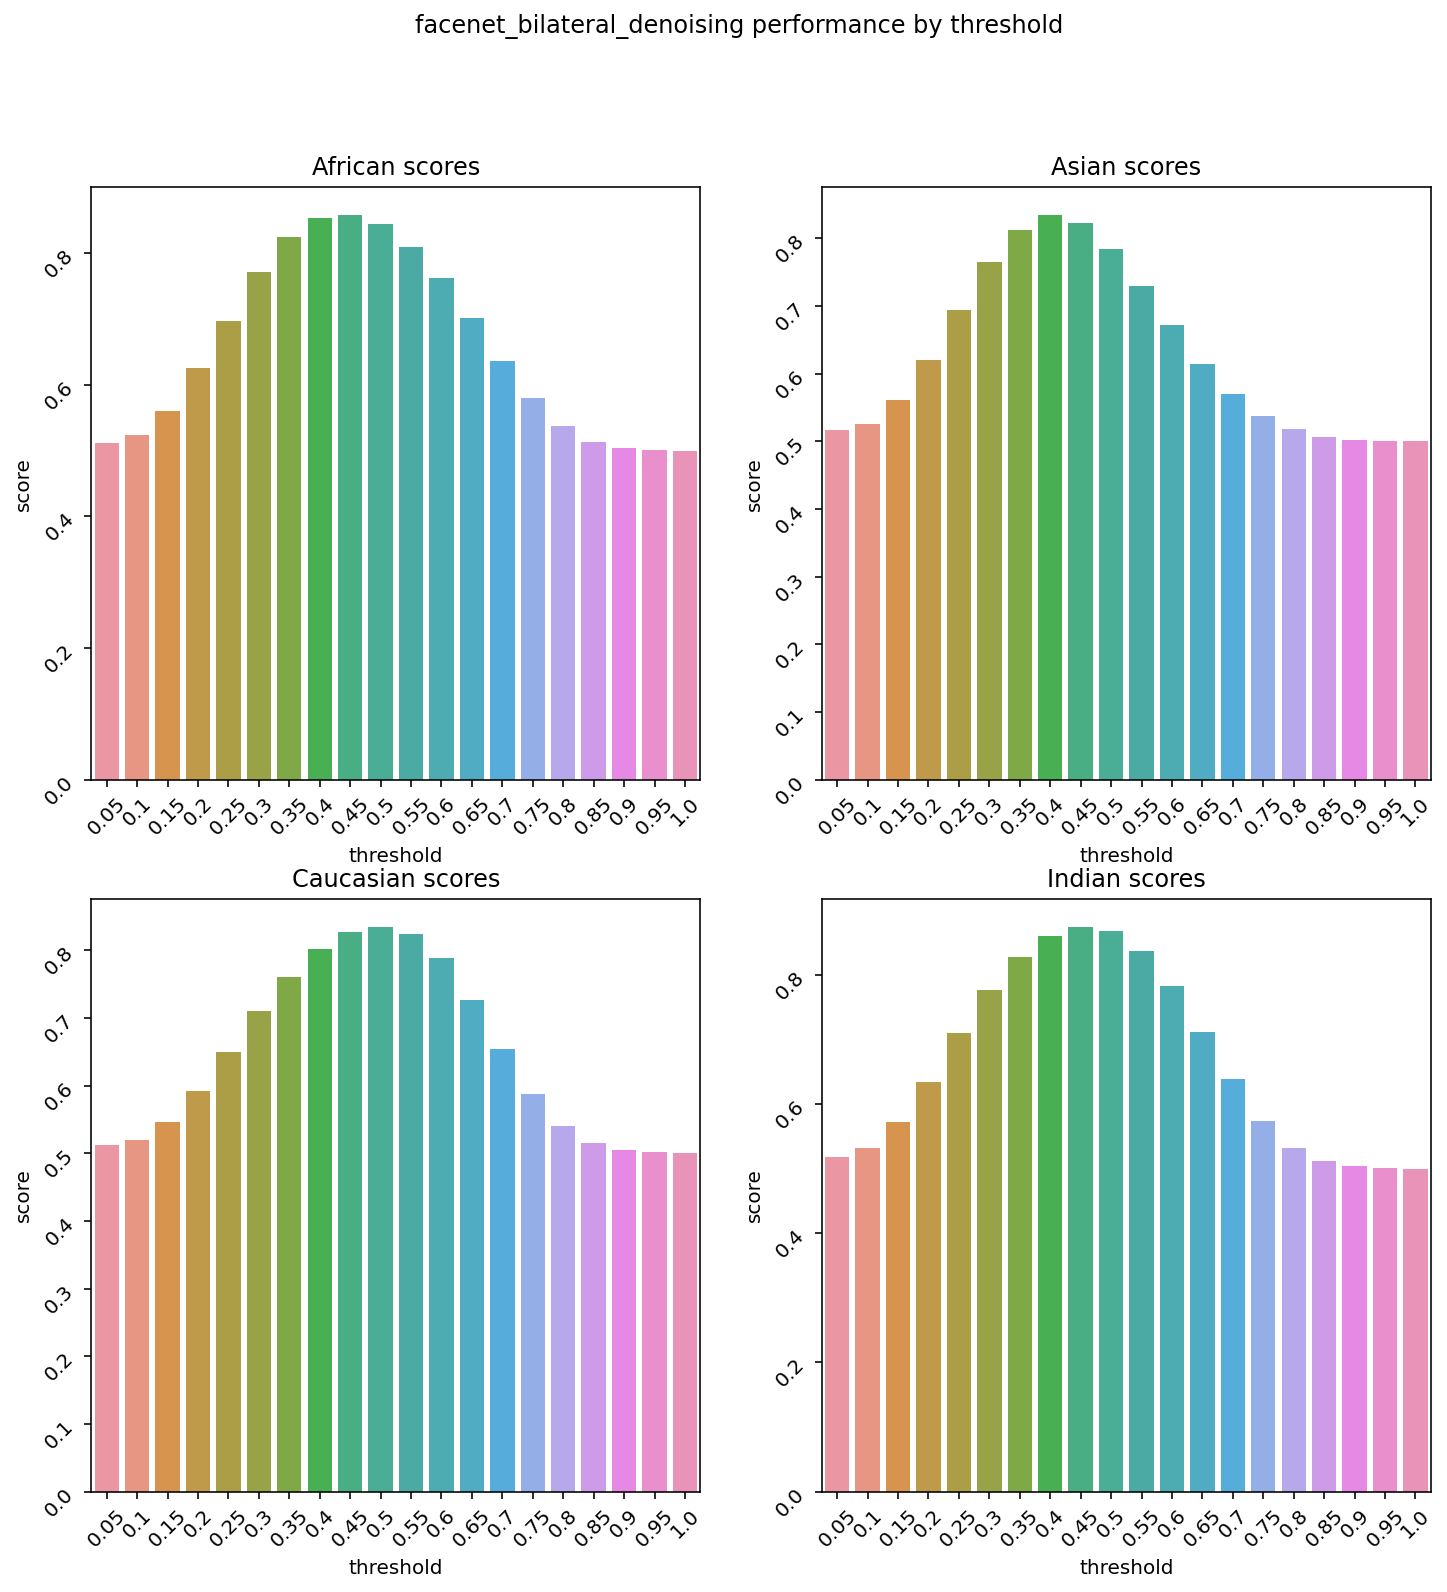

In [11]:
plot_performance_per_threshold(facenet_model)

**Result**:
* Significant performance drop from Indian to Asian (appx. 10% AUROC and accuracy)
* Interestingly Indian lower CI is higher than higher CI of Caucasians
* CI of Asians is also wider
* Best performing thresholds differ. Especially Asian which tells us that one threshold might not make sense

### VGG-Face

In [12]:
vgg_face_model = "vgg_face_bilateral_denoising"


In [13]:
vgg_summary = get_metric_comparision(vgg_face_model, roc_auc_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.888300,0.887111,0.889488
0,Asian,0.840737,0.839342,0.842133
0,African,0.834004,0.832411,0.835598
0,Caucasian,0.814661,0.813072,0.816251


In [14]:
vgg_summary = get_metric_comparision(vgg_face_model, accuracy_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.756180,0.754667,0.757693
0,Caucasian,0.748493,0.746834,0.750152
0,African,0.696517,0.694815,0.698218
0,Asian,0.639267,0.637558,0.640975


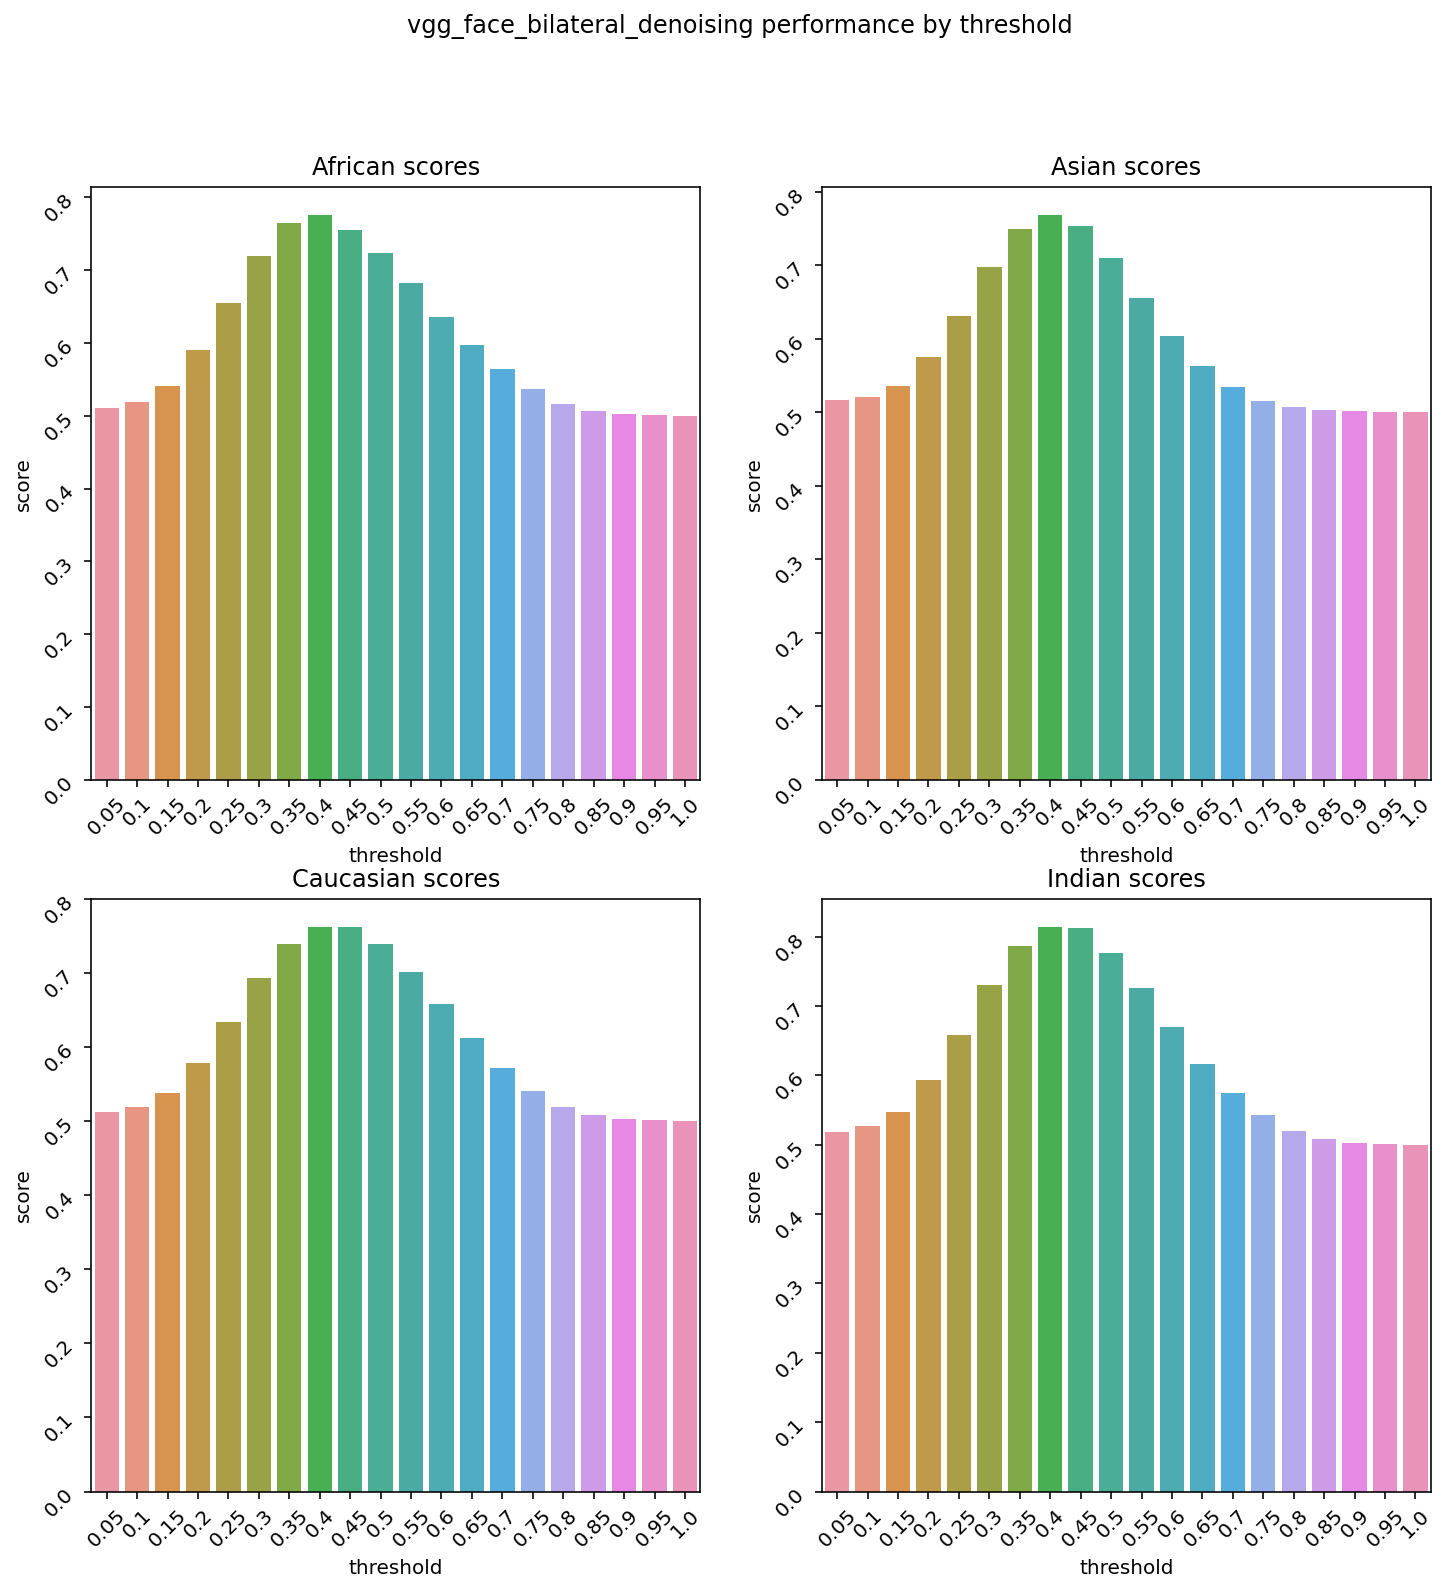

In [15]:
plot_performance_per_threshold(vgg_face_model)

**Result**:
* Overall performance is worse than with FaceNet512
* Mean performance is though only 6% difference between highest and lowest, indicating more fairness
* Varying performance for Asians again
* Partly overlapping CIs
* Thresholds are more fair which is reflected in the fair performance

### ArcFace

In [16]:
arcface_model = "arcface_bilateral_denoising"

In [17]:
arcface_summary = get_metric_comparision(arcface_model, roc_auc_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,African,0.807104,0.805452,0.808755
0,Indian,0.803187,0.801578,0.804797
0,Caucasian,0.781660,0.779937,0.783382
0,Asian,0.761971,0.760378,0.763565


In [18]:
arcface_summary = get_metric_comparision(arcface_model, accuracy_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.655027,0.653318,0.656735
0,African,0.648873,0.647020,0.650727
0,Caucasian,0.646987,0.645293,0.648680
0,Asian,0.630860,0.629294,0.632426


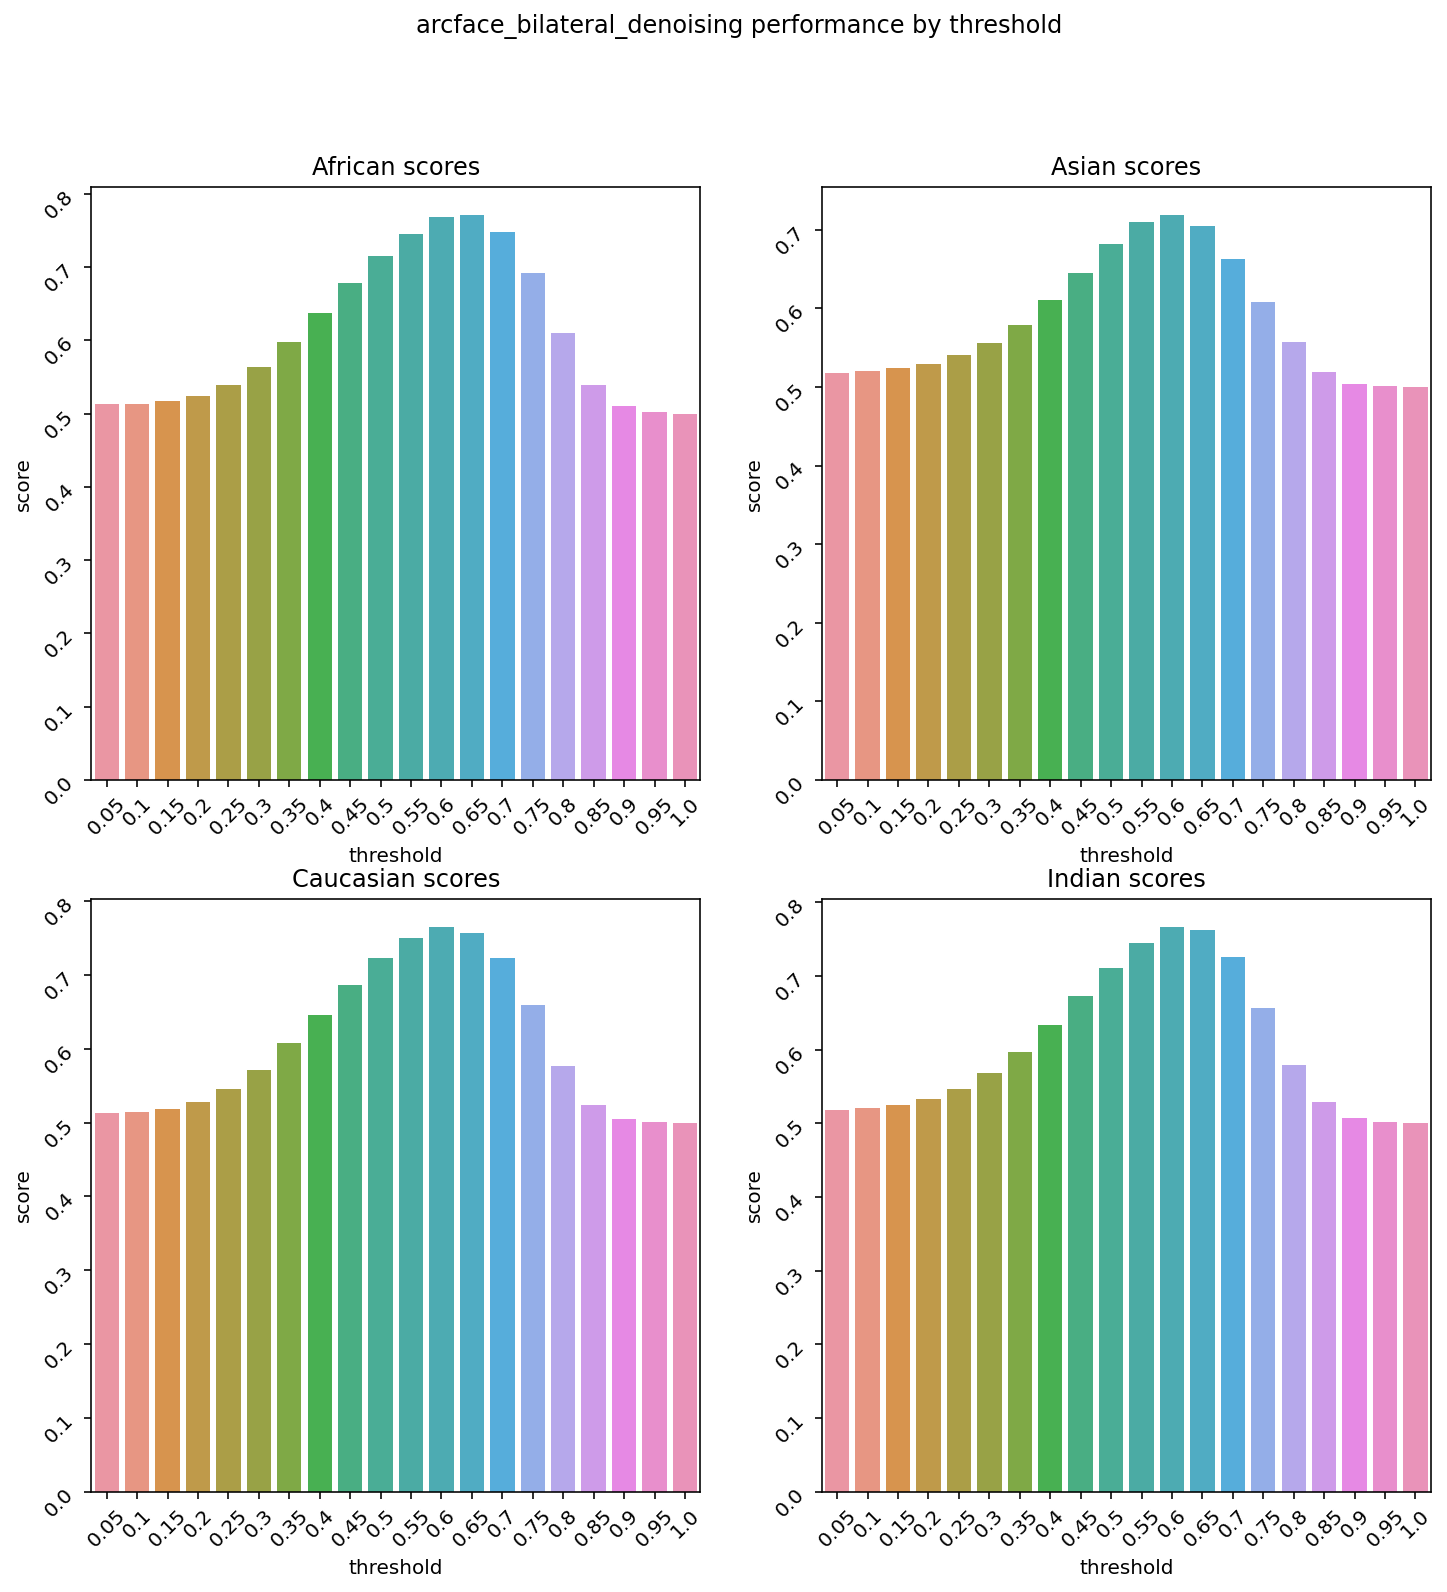

In [19]:
plot_performance_per_threshold(arcface_model)

**Result**:
* Worst overall performance
* Only 5% decrease between best and worst which seems to be fairer
* Asians again wide CI compared to e.g. Caucasian
* Best thresholds is shifted to the right but rather similar

## Distance distribution

This is the distribution of the predicted distance between the pairs. In a first plot they will be generally visualised and then paised on pairs vs. non-pairs.
An ideal model would predict two peaking curves on the outer ends of the plot indicating good discrimination.

### FaceNet512

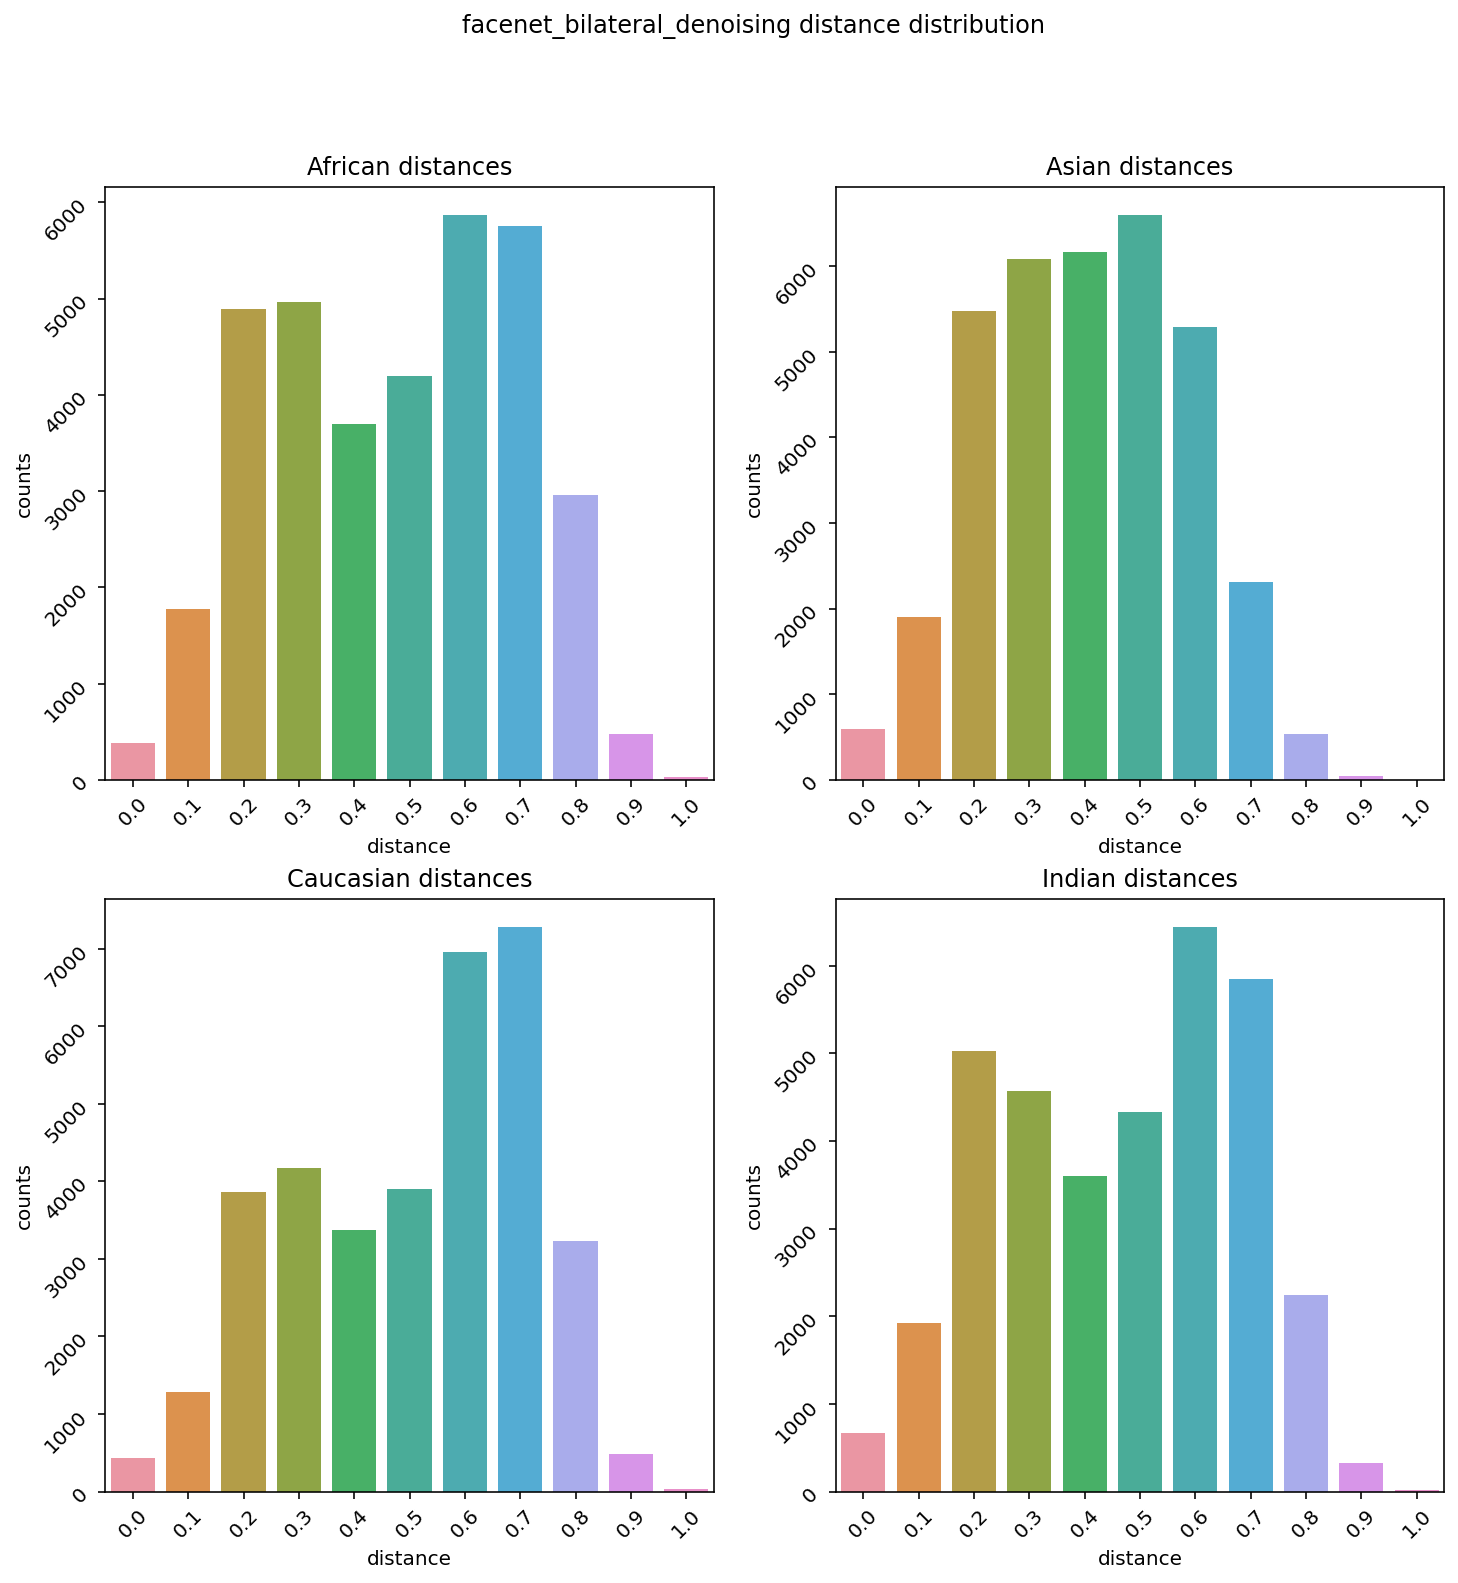

In [20]:
plot_score_distribution(facenet_model)

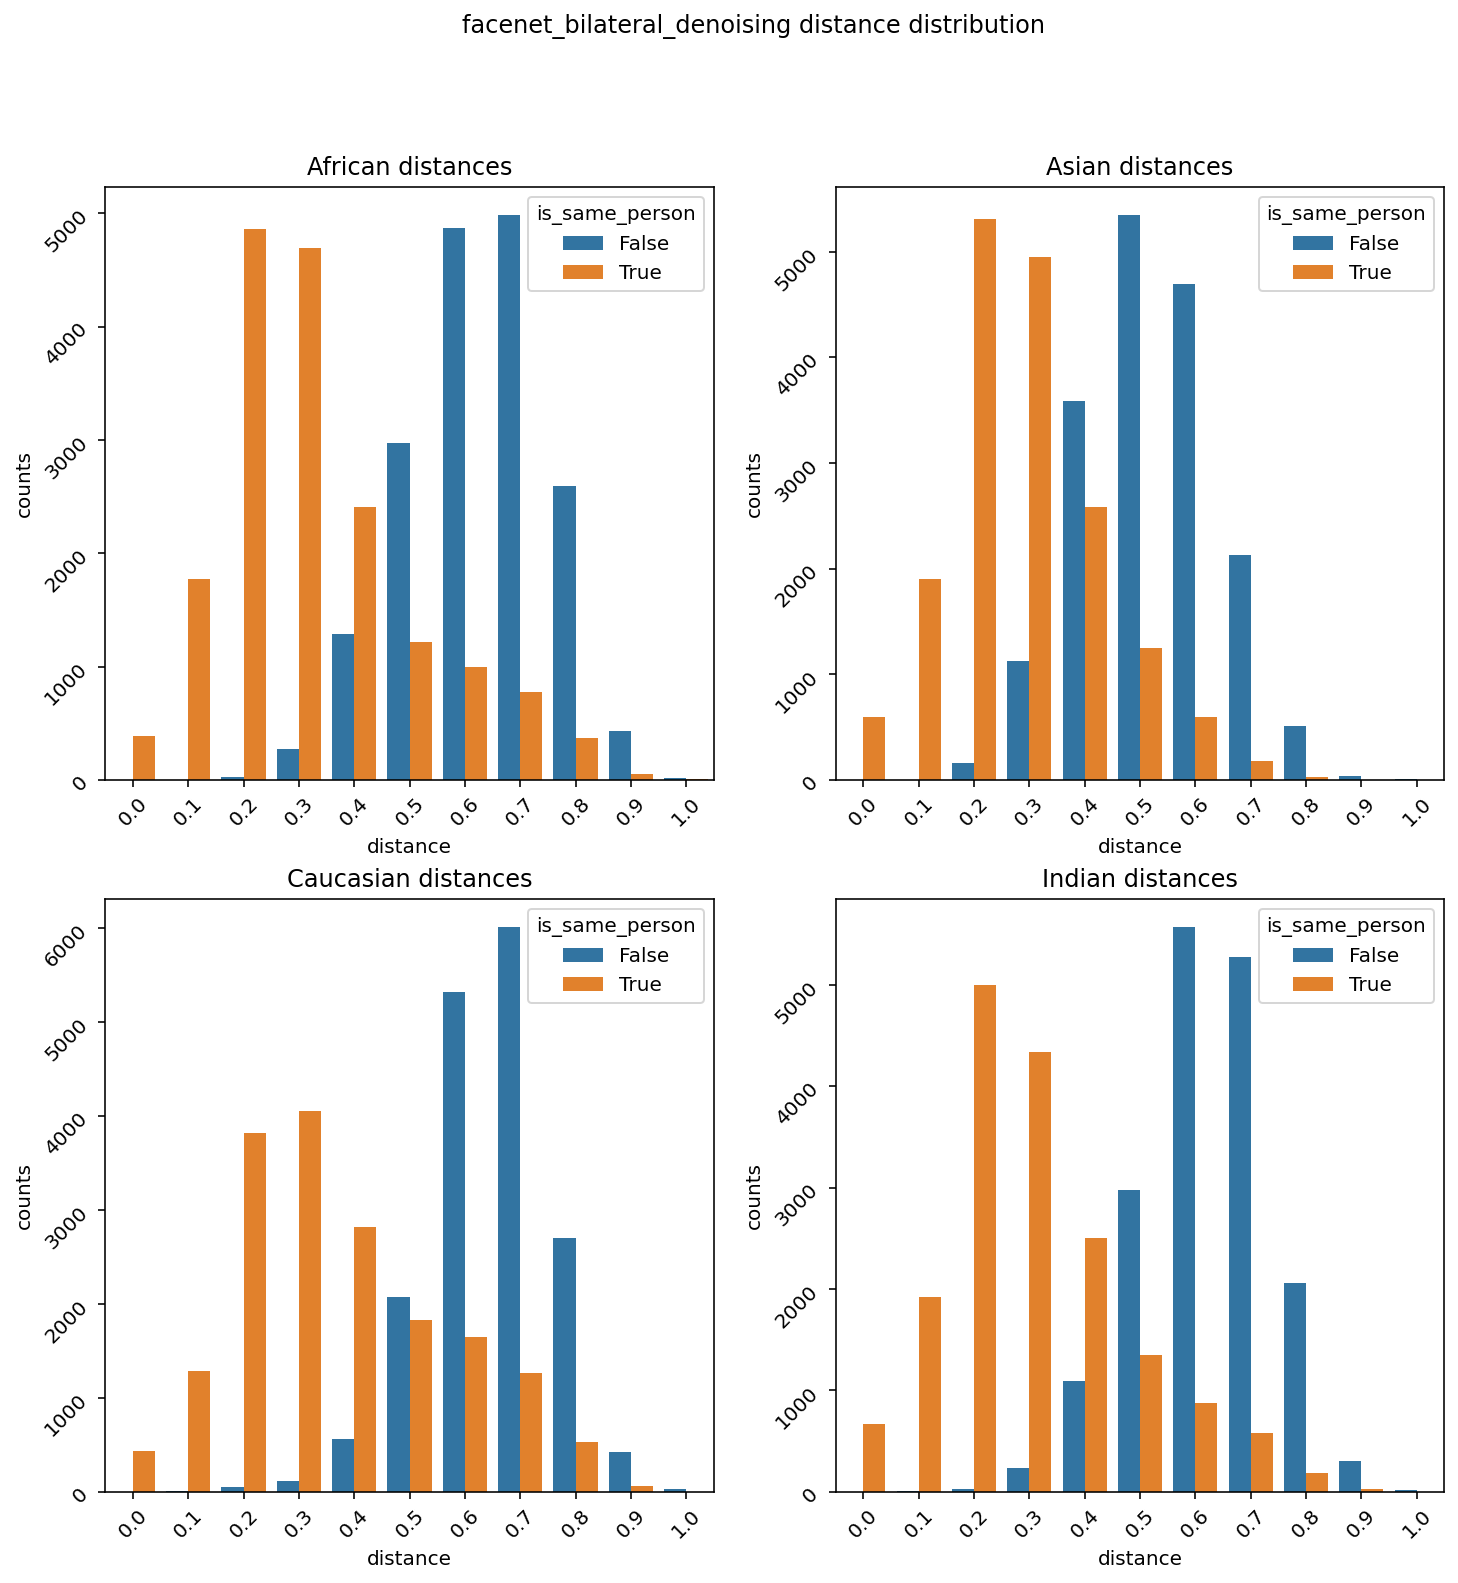

In [21]:
plot_score_distribution(facenet_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [22]:
print("Asian difference in mean:",calculate_distribution_difference(facenet_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(facenet_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(facenet_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(facenet_model,"Indian"))

Asian difference in mean: -0.34599559594849677
African difference in mean: -0.4326776962302334
Caucasian difference in mean: -0.4174489681861643
Indian difference in mean: -0.45363286343413517


**Results**:
* Only the Asian model does not show two spiking parts. This means the distinction is done very badly. For the three other spikes are at least visible.
* All models have heavy overlaps which means there is always a trade off when choosing a threshold.
* Only the asian threshold is shifted to the left.

### VGG-Face


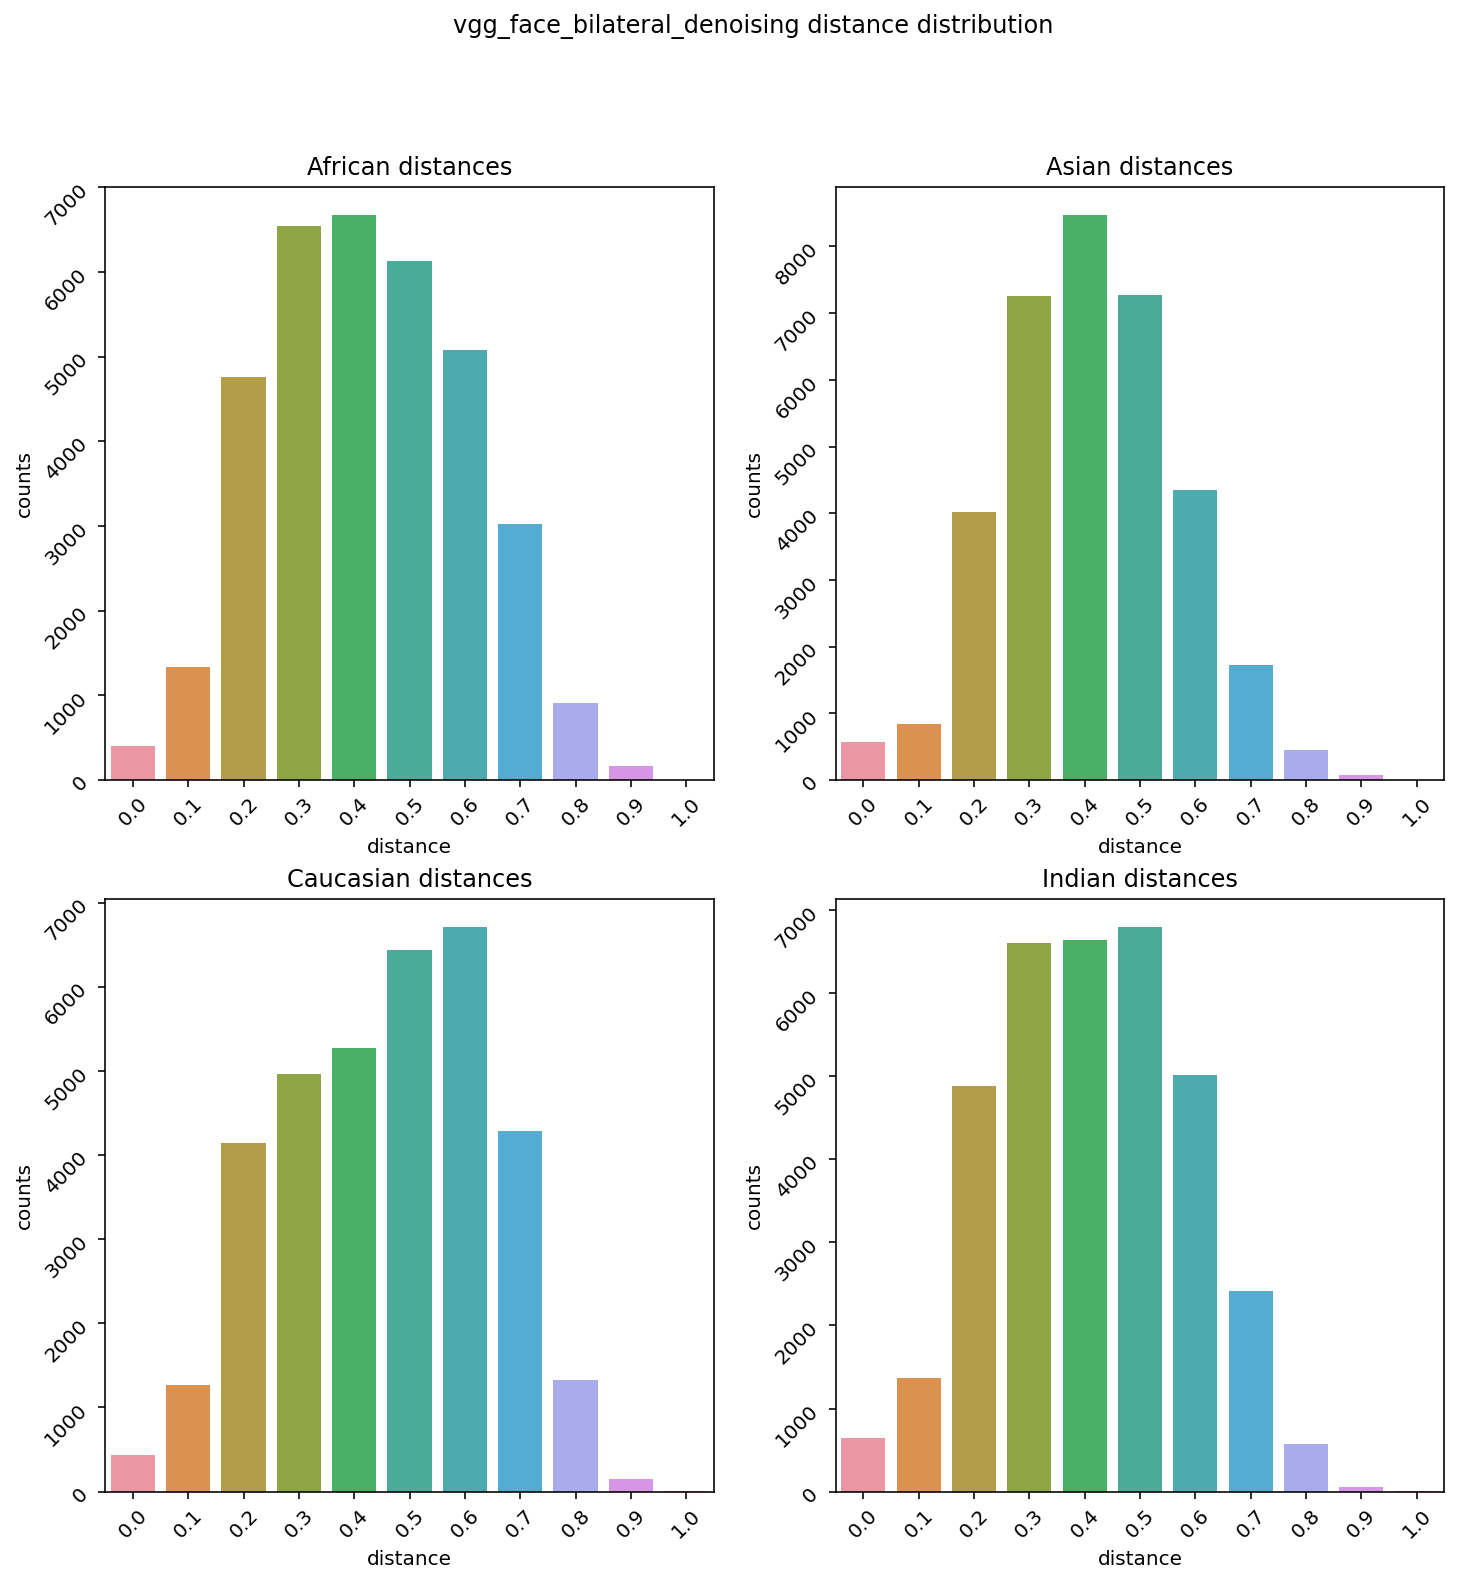

In [23]:
plot_score_distribution(vgg_face_model)

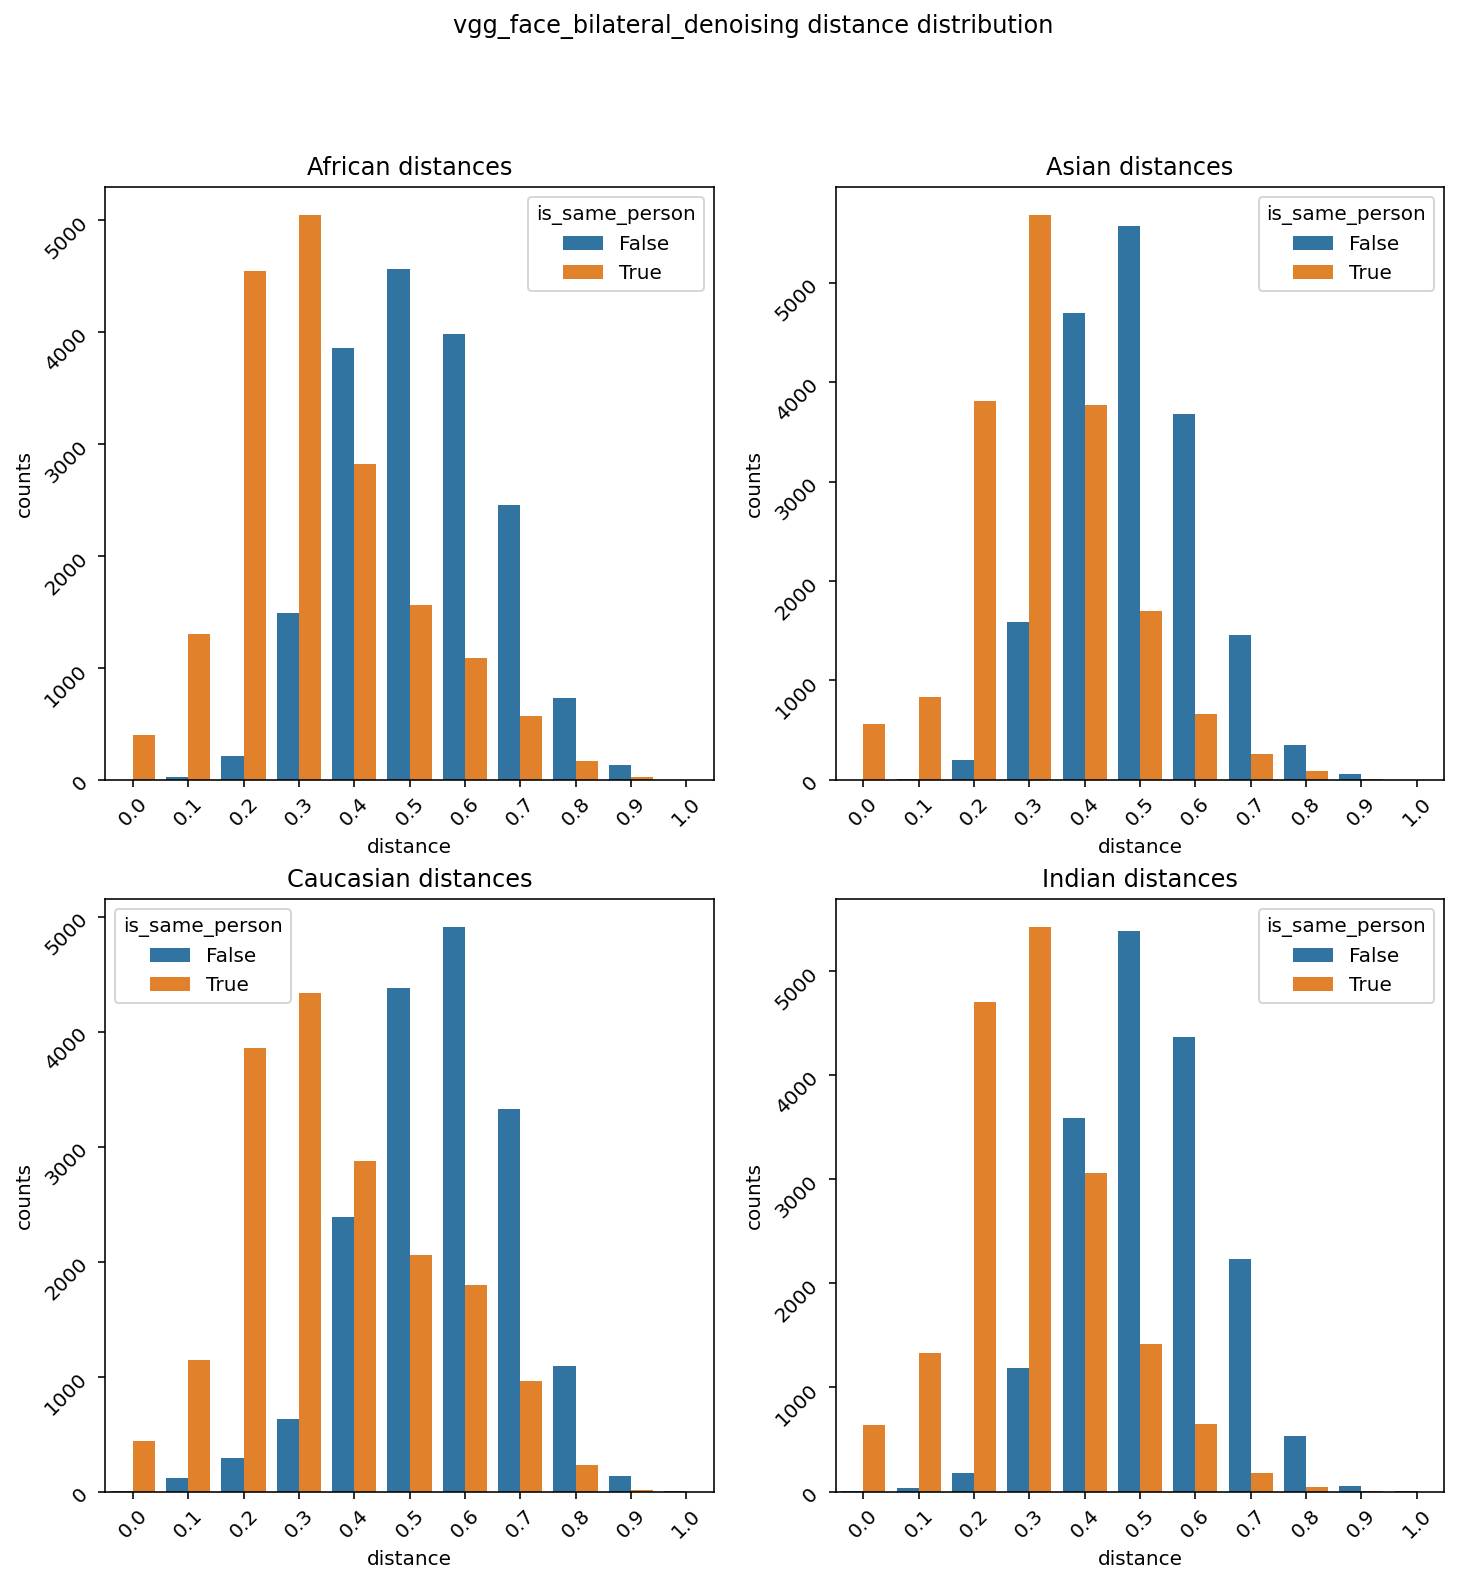

In [24]:
plot_score_distribution(vgg_face_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [25]:
print("Asian difference in mean:",calculate_distribution_difference(vgg_face_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(vgg_face_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(vgg_face_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(vgg_face_model,"Indian"))

Asian difference in mean: -0.1642679373853277
African difference in mean: -0.19739935353467936
Caucasian difference in mean: -0.21598625226648627
Indian difference in mean: -0.23285254023657842


**Results**:
* No spikes in any ethnic group indicating bad discrimination.
* Even heavier overlaps = worse performance

### ArcFace

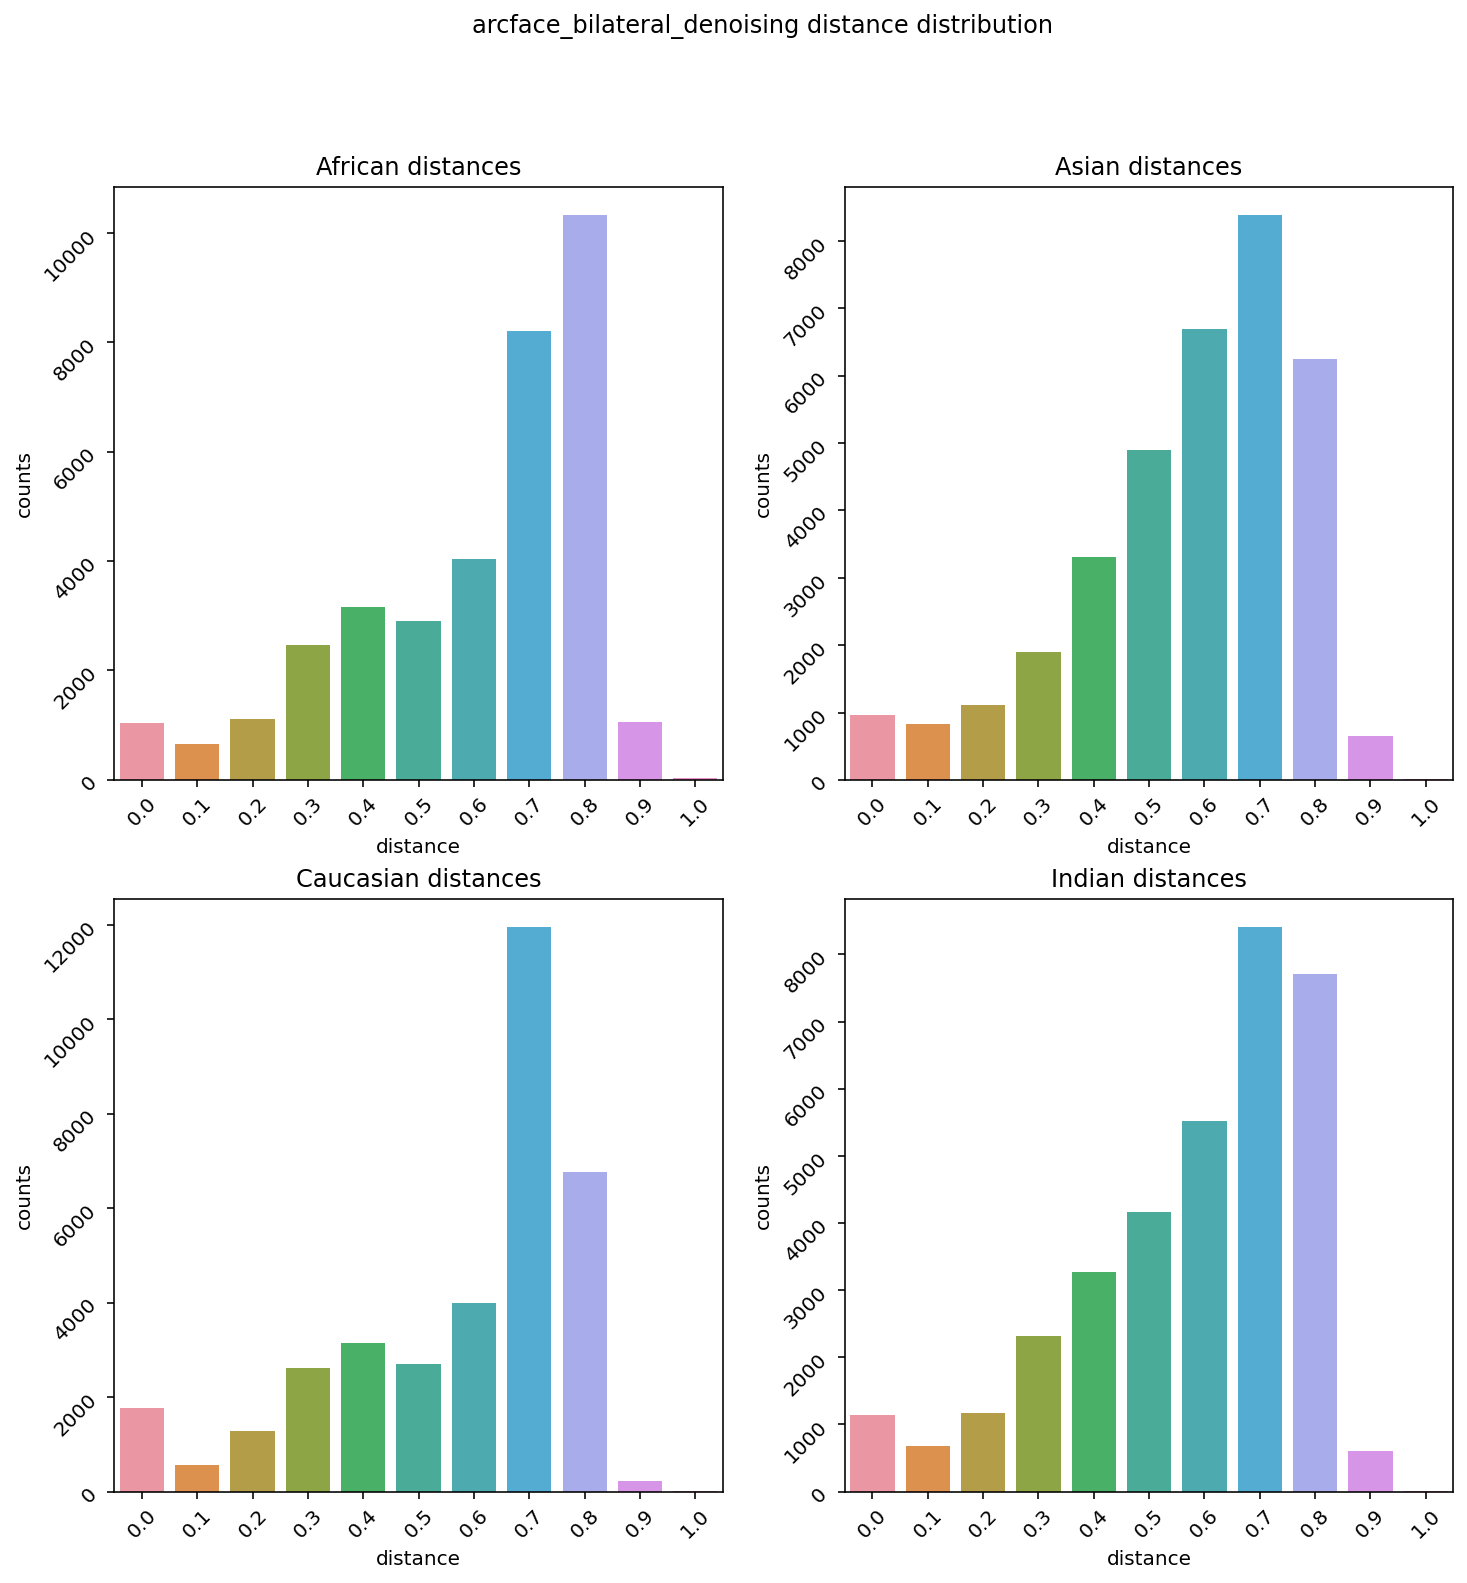

In [26]:
plot_score_distribution(arcface_model)

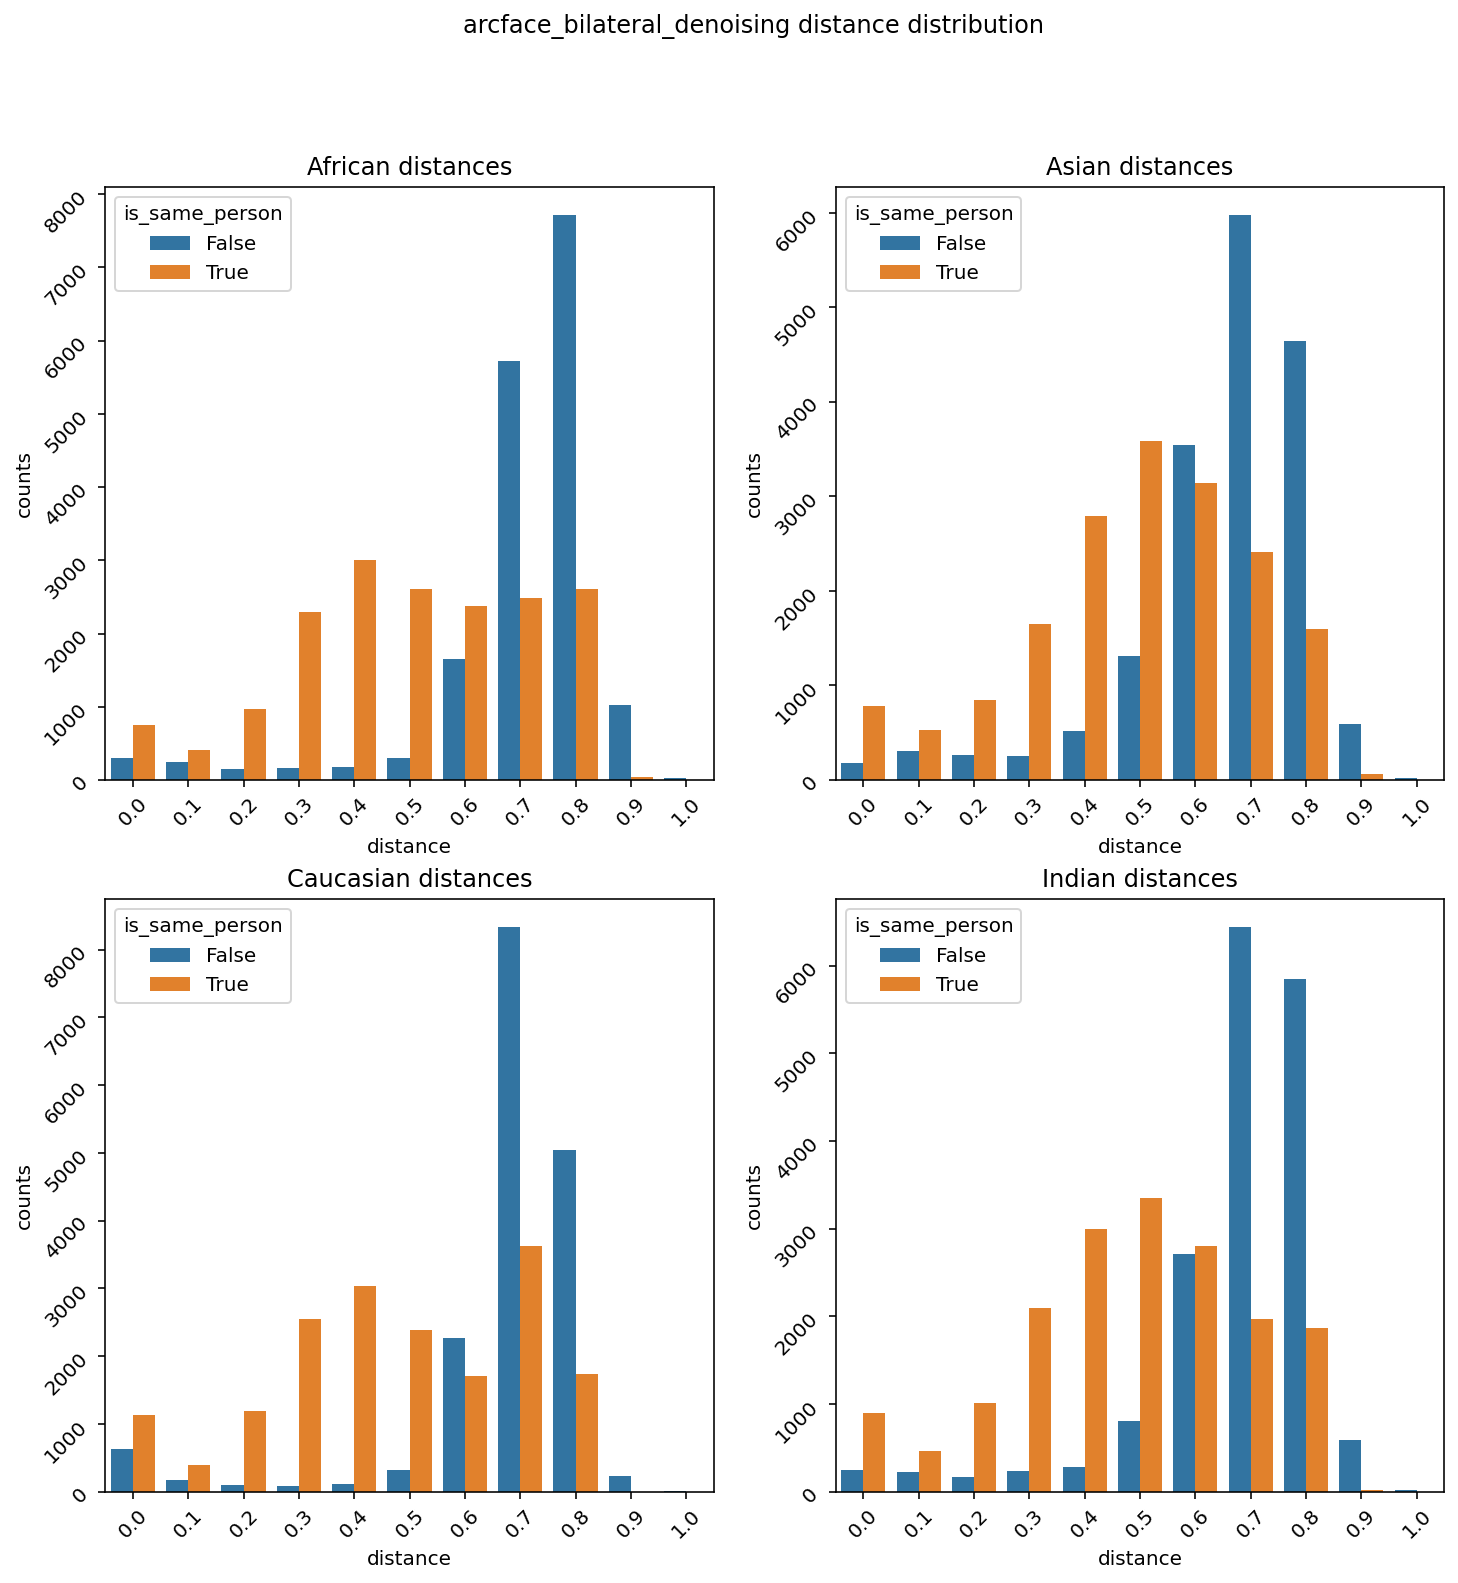

In [27]:
plot_score_distribution(arcface_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [28]:
print("Asian difference in mean:",calculate_distribution_difference(arcface_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(arcface_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(arcface_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(arcface_model,"Indian"))

Asian difference in mean: -0.19797342932216921
African difference in mean: -0.2631871700087244
Caucasian difference in mean: -0.26226284582617665
Indian difference in mean: -0.24833799802254286


**Results**:
* For all groups there are one or two spikes around 0.7 & 0.8
* Also the amount of non-pairs with 0 distance is significantly higher
* The distance of pairs is partly uniformly distributed (see African distances)
* Almost no discrimination power
* Generally big shift to the higher distances, might be due to geometric approach of ArcFace

## Paired significance tests

Usually a paired t-test would be the desired solution. However the normal distribution of the target variable is not fulfilled which is why we will go with a Wilcoxon-Signed-Rank-Test which is slightly less effective but has less assumptions.

The goal is to investigate if there are significant differences in the mean of the ethnic groups produced by a model. An unbiased model would present similar results. The two-sided test has the null hypothesis that the median of the differences is zero against the alternative that it is different from zero.

For independent sample we will use the Wilcoxon-RankSum-Test (NUll hypothesis = the observations come from the same population).

### General

The first step is to generate all possible combinations of comparisons

In [29]:
def perform_significance_test(model1, model2, ethnic, test_type = st.wilcoxon):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for j in range(1,6):
        with open(f'results/{model1}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data1 = data1.append(data_temp)
        
        with open(f'results/{model2}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data2 = data2.append(data_temp)        

    return test_type(data1.distance, data2.distance)


In [30]:
ethnic_groups = ["Caucasian", "Asian", "African", "Indian"]

### FaceNet512

In [31]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance:",perform_significance_test("facenet", facenet_model, ethnic)[1])

Wilcoxon test on Caucasian performance: 2.483312767100075e-11
Wilcoxon test on Asian performance: 0.00028462562413262985
Wilcoxon test on African performance: 9.754405251271263e-13
Wilcoxon test on Indian performance: 1.302280467221364e-24


**Results**:
* Testing all combinations lets us reject all null hypothesises

### VGG-Face

In [32]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("vgg_face", vgg_face_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  0.13984459888012304
Wilcoxon test on Asian performance:  1.4933055281770538e-18
Wilcoxon test on African performance:  2.6795903301830015e-19
Wilcoxon test on Indian performance:  8.690390428441172e-06


**Results**:
* Testing all combinations lets us reject all null hypothesises

### ArcFace

In [33]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("arcface", arcface_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  3.5309177818759355e-24
Wilcoxon test on Asian performance:  3.8247168021381504e-152
Wilcoxon test on African performance:  5.77121349478179e-32
Wilcoxon test on Indian performance:  1.1044657582839455e-45


**Results**:
* Testing all combinations lets us reject all null hypothesises

## Image description with Lime

Differnent models identify different areas in an image as important. Here we want to compare which areas are important to which model.

Ideally the ethic groups should be described similarly.

### General

In [34]:
asian_img_path ='data/race_per_7000/Asian/m.03cfpv1/000050_00@en.jpg'
african_img_path = 'data/race_per_7000/African/m.03v416/32-FaceId-0_align.jpg'
caucasian_img_path = 'data/race_per_7000/Caucasian/m.0356k8/26-FaceId-0_align.jpg'
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'

### FaceNet512

In [35]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(160,160), preprocessing = bilateral_denoising)
african_img = load_image(path=african_img_path,shape=(160,160), preprocessing = bilateral_denoising)
caucasian_img = load_image(path=caucasian_img_path,shape=(160,160), preprocessing = bilateral_denoising)
indian_img = load_image(path=indian_img_path,shape=(160,160), preprocessing = bilateral_denoising)

In [36]:
facenet512 = DeepFace.build_model("Facenet512")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 26.73433365707273
Prediction_local [12.8145628]
Right: 12.4158325
Intercept 29.334595091209838
Prediction_local [12.93204295]
Right: 12.512335


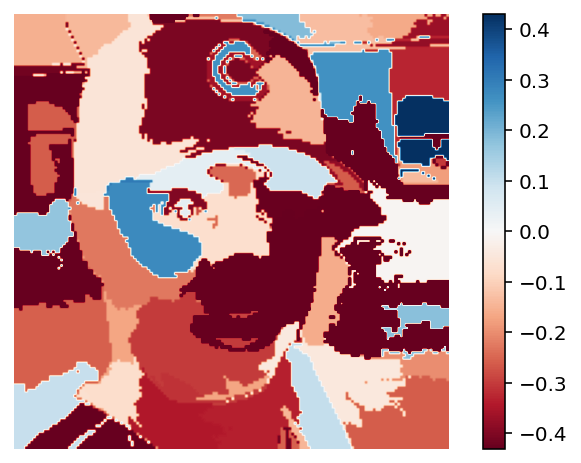

In [37]:
plot_face_heatmap(facenet512, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 30.626973168292253
Prediction_local [19.33336979]
Right: 18.791
Intercept 29.50318700998494
Prediction_local [20.65706488]
Right: 20.153233


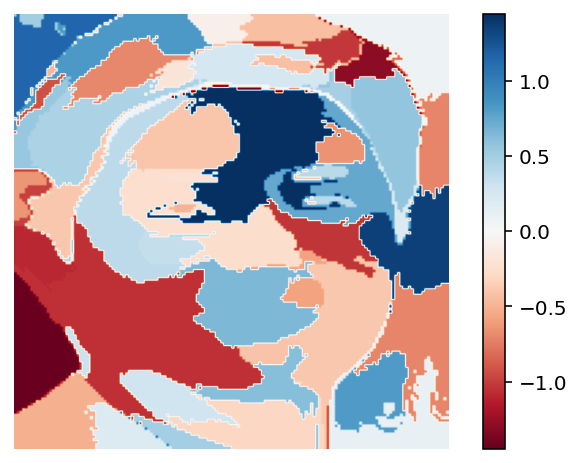

In [38]:
plot_face_heatmap(facenet512, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 20.114487405170298
Prediction_local [9.66355185]
Right: 9.533717
Intercept 16.066527111117303
Prediction_local [9.86776006]
Right: 9.868954


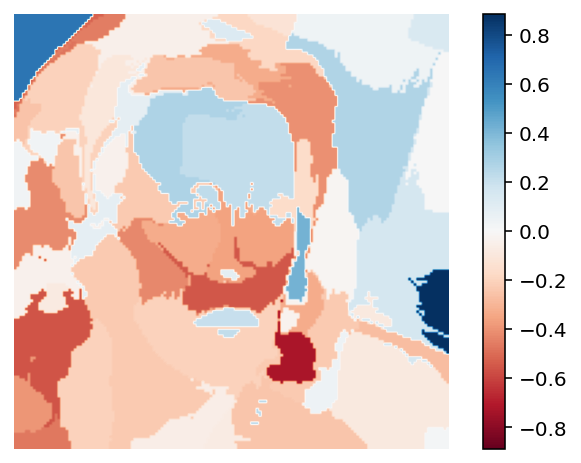

In [39]:
plot_face_heatmap(facenet512, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 23.365699649754475
Prediction_local [16.44361997]
Right: 16.355577
Intercept 33.368399396652464
Prediction_local [16.7841664]
Right: 16.49323


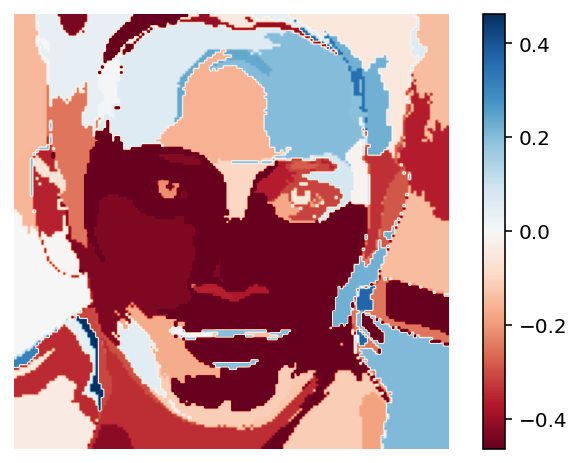

In [40]:
plot_face_heatmap(facenet512, indian_img)

### VGG-Face

In [41]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(224,224), preprocessing = bilateral_denoising)
african_img = load_image(path=african_img_path,shape=(224,224), preprocessing = bilateral_denoising)
caucasian_img = load_image(path=caucasian_img_path,shape=(224,224), preprocessing = bilateral_denoising)
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = bilateral_denoising)

In [42]:
vgg_face = DeepFace.build_model("VGG-Face")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -6.176637450221607
Prediction_local [12.37932543]
Right: 12.799406
Intercept -3.469161870803412
Prediction_local [12.68284983]
Right: 13.082369


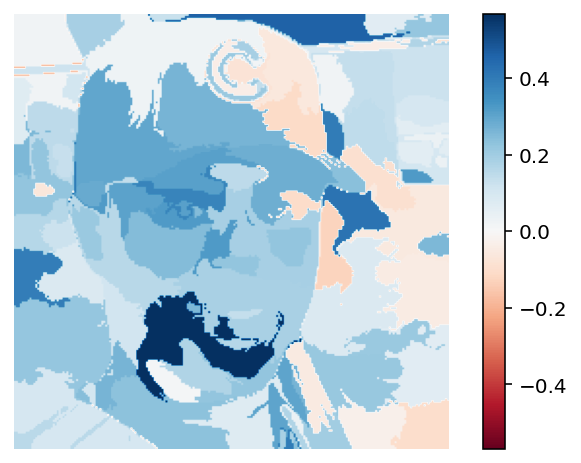

In [43]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -5.182859391857383
Prediction_local [12.43066471]
Right: 12.799406
Intercept -2.5650763153512433
Prediction_local [12.76442579]
Right: 13.082369


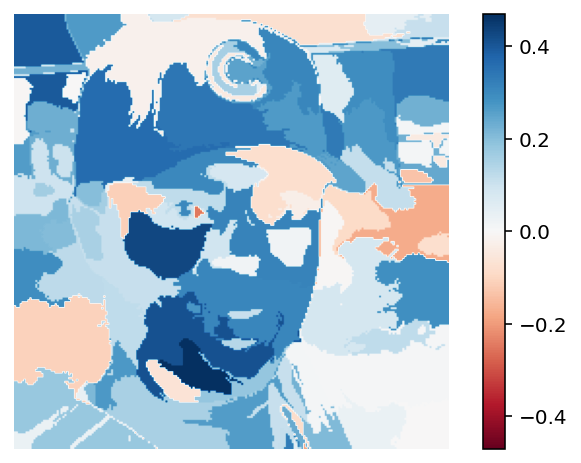

In [44]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -3.9337594830099816
Prediction_local [14.65490608]
Right: 15.194869
Intercept -4.288173312945642
Prediction_local [15.25794677]
Right: 15.721769


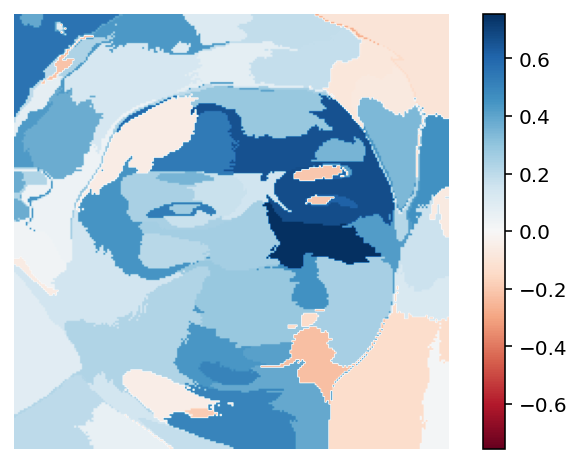

In [45]:
plot_face_heatmap(vgg_face, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -14.667382950794353
Prediction_local [17.12293218]
Right: 18.057007
Intercept -13.894485423074585
Prediction_local [18.74493299]
Right: 19.550575


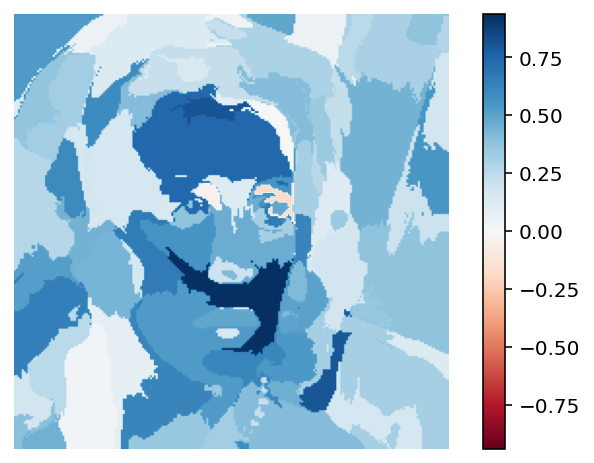

In [46]:
plot_face_heatmap(vgg_face, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -2.7195091817481742
Prediction_local [11.4873798]
Right: 11.660725
Intercept -2.9019939646770645
Prediction_local [11.74649906]
Right: 11.924807


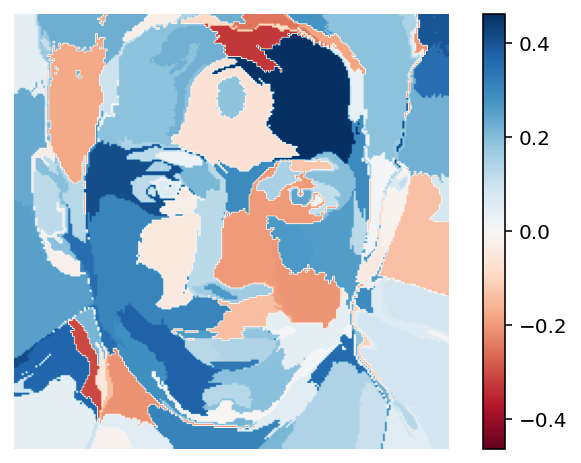

In [47]:
plot_face_heatmap(vgg_face, indian_img)

### ArcFace

In [48]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(112,112), preprocessing = bilateral_denoising)
african_img = load_image(path=african_img_path,shape=(112,112), preprocessing = bilateral_denoising)
caucasian_img = load_image(path=caucasian_img_path,shape=(112,112), preprocessing = bilateral_denoising)
indian_img = load_image(path=indian_img_path,shape=(112,112), preprocessing = bilateral_denoising)

In [49]:
arcface = DeepFace.build_model("ArcFace")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 397.1449377898774
Prediction_local [895.35994014]
Right: 927.2666
Intercept 587.540039021841
Prediction_local [1172.66212861]
Right: 1199.0742


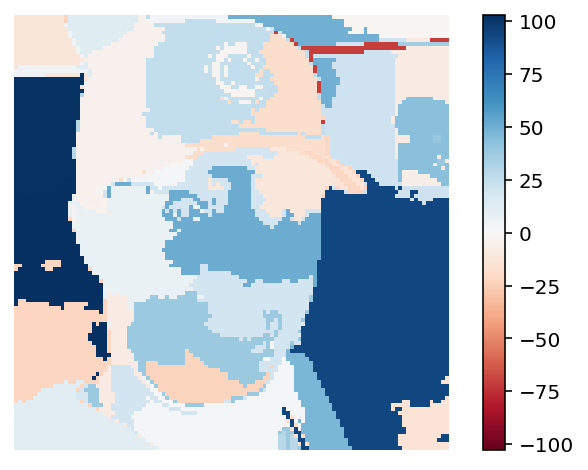

In [50]:
plot_face_heatmap(arcface, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 1314.7507154610398
Prediction_local [1491.61105097]
Right: 1470.8325
Intercept 549.6391195006481
Prediction_local [1736.43753962]
Right: 1780.4125


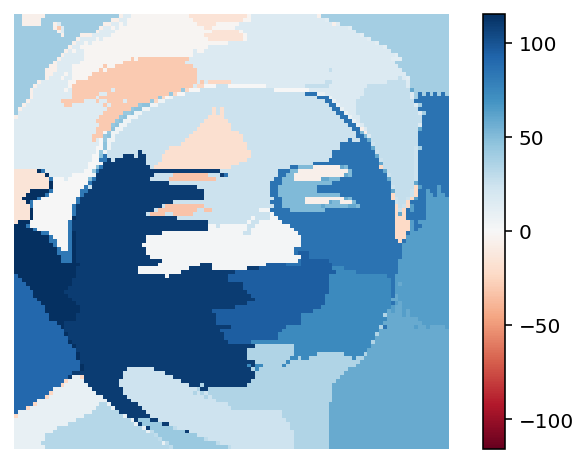

In [51]:
plot_face_heatmap(arcface, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 497.7890057810373
Prediction_local [888.0810648]
Right: 895.0203
Intercept 780.5453069540724
Prediction_local [1174.50843745]
Right: 1168.5691


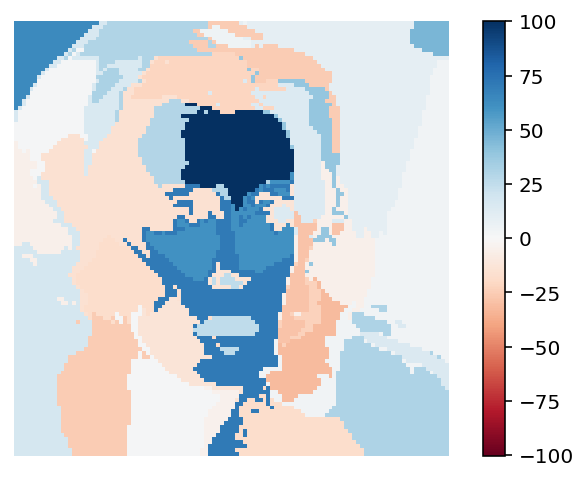

In [52]:
plot_face_heatmap(arcface, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 586.2205073967539
Prediction_local [1095.26350405]
Right: 1113.6371
Intercept 985.2777332714653
Prediction_local [1452.65049508]
Right: 1458.6119


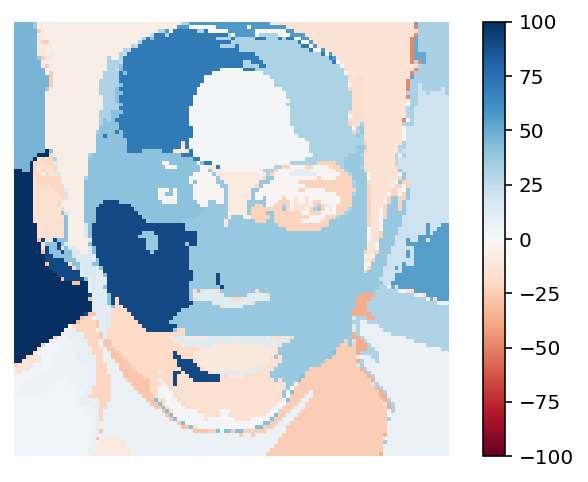

In [53]:
plot_face_heatmap(arcface, indian_img)

**Results**:
* Caucasian image has important forehead on all models
* ArcFace does not detect same face patterns for African as others